In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [26]:
df = pd.read_csv("nyc_taxi_trip_duration.csv")

In [27]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


- convert datatime from object to datatime series

In [28]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)

In [29]:
df.store_and_fwd_flag=(df.store_and_fwd_flag=='Y')*1

In [30]:
df.trip_duration=df.trip_duration.apply(lambda x : np.log(x))

In [31]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,5.991465
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,7.003065
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,7.399398
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,7.039660
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,6.742881


# Feature engineering

In [32]:
colms=["Hour","dayofweek","Month"]
hour=df.pickup_datetime.dt.hour
dayofweek=df.pickup_datetime.dt.dayofweek
month=df.pickup_datetime.dt.month

df_Time=pd.DataFrame({'Hour' : hour,
                     'DayofWeek': dayofweek,
                     'month': month})

In [33]:
df= pd.concat([df,df_Time],axis=1)

In [34]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Hour,DayofWeek,month
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,5.991465,16,0,2
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,7.003065,23,4,3
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,7.399398,17,6,2
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,7.039660,9,1,1
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,6.742881,6,2,2


- As distnace is something which we need mostly to calculate trip duration lets add some more columns related to distance

In [35]:
lon=df.pickup_longitude-df.dropoff_longitude
lat=df.pickup_latitude-df.dropoff_latitude

In [36]:
df['Differnce']=lon+lat

In [39]:
df['Sqr_Differnce']=(lon**2)+(lat**2)
df['Sqroot_sqrDiffernce']=df["Sqr_Differnce"]**0.5

In [40]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Hour,DayofWeek,month,Differnce,Sqr_Differnce,Sqroot_sqrDiffernce
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,5.991465,16,0,2,0.017666,0.000159,0.012592
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,7.003065,23,4,3,0.043251,0.001397,0.037371
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,7.399398,17,6,2,-0.102745,0.005287,0.072712
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,7.039660,9,1,1,-0.025799,0.000461,0.021473
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,6.742881,6,2,2,-0.061100,0.001872,0.043264


In [41]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


In [108]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Hour,DayofWeek,month,Differnce,Sqr_Differnce,Sqroot_sqrDiffernce,haversine_distance,direction,pickup_latitude_round3
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,5.991465,16,0,2,0.017666,0.000159,0.012592,1.199073,-135.634530,40.779
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,7.003065,23,4,3,0.043251,0.001397,0.037371,4.129111,-172.445217,40.732
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,7.399398,17,6,2,-0.102745,0.005287,0.072712,7.250753,34.916093,40.721
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,7.039660,9,1,1,-0.025799,0.000461,0.021473,2.361097,10.043567,40.760
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,6.742881,6,2,2,-0.061100,0.001872,0.043264,4.328534,34.280582,40.708


In [48]:
df_c=df.drop(["id","pickup_datetime","dropoff_datetime"],axis=1)

In [50]:
from sklearn.model_selection import train_test_split
X=df_c.drop("trip_duration",axis=1)
Y=df_c["trip_duration"]

In [58]:
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.2,random_state=42)

In [75]:
lr=LinearRegression()
lrm=lr.fit(train_x,train_y)
pred=lr.predict(train_x)
testpred=lr.predict(test_x)
mean_squared_error(pred,train_y),mean_squared_error(testpred,test_y)

(0.38125382532466817, 0.3822799885776143)

In [78]:
dcs=DecisionTreeRegressor(max_depth=3)

In [79]:
dcsm=dcs.fit(train_x,train_y)


(0.2671349198468593, 0.267523810061904)

In [80]:
pred=dcs.predict(train_x)
testpred=dcs.predict(test_x)
mean_squared_error(pred,train_y),mean_squared_error(testpred,test_y)

(0.2671349198468593, 0.267523810061904)

In [133]:
def cv_score(model):
    cvscore=np.array([])
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    for train_index,test_index in kf.split(X,Y):
        xtr,xte=X.loc[train_index],X.loc[test_index]
        ytr,yte=Y.loc[train_index],Y.loc[test_index]
        ml=model
        mymodel=ml.fit(xtr,ytr)
        m_pred=mymodel.predict(xte)
        rmse=(mean_squared_error(m_pred,yte))**0.5
        cvscore=np.append(cvscore,rmse)
    return cvscore
    

In [134]:
cv_score(LinearRegression())

array([0.61828795, 0.62083776, 0.63986544, 0.62088039, 0.67469524])

In [135]:
cv_score(DecisionTreeRegressor())

array([0.58025297, 0.57746049, 0.57989918, 0.58178291, 0.58353427])

In [160]:
rec_score=np.array([])
for i in range (10,16):
    sc=cv_score(DecisionTreeRegressor(max_depth=i)).mean()
    print(sc)
    rec_score=np.append(rec_score,sc)
    

0.44779251168032336
0.44669102088415863
0.44900189892442877
0.4539616849776474
0.46002268927339796
0.47070880203196735


In [161]:
rec_score

array([0.44779251, 0.44669102, 0.4490019 , 0.45396168, 0.46002269,
       0.4707088 ])

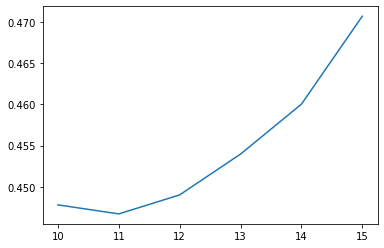

In [162]:
plt.plot(range(10,16),rec_score)

- as we can see theres increase after 11 we can say max depth is best around 11

# comparism b/w logistic and decision tree

In [164]:
log=cv_score(LinearRegression())

In [165]:
dec=cv_score(DecisionTreeRegressor(max_depth=11))

In [166]:
df_ld=pd.DataFrame({'log': log,
                   'dec': dec})

Text(0, 0.5, 'RMSE')

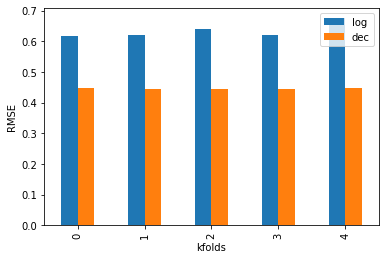

In [177]:
df_ld.plot(y=["log","dec"],kind='bar')
plt.xlabel("kfolds")
plt.ylabel("RMSE")



- We can conclude that decision tree is better model at maxdepth around 11
- Reason might be non linear datas 